# Optimal transport approximation via Sinkhorn iterations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances

## Set up problem/regularisation

sinkhorn distance: 0.015823824104763514


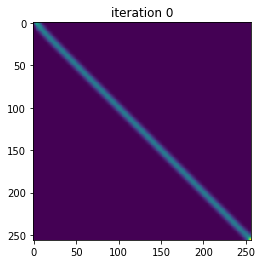

sinkhorn distance: 0.17729530005773403


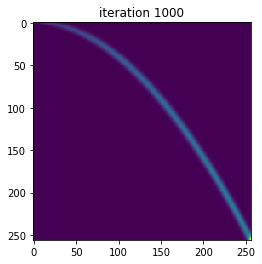

sinkhorn distance: 0.1843696287668441


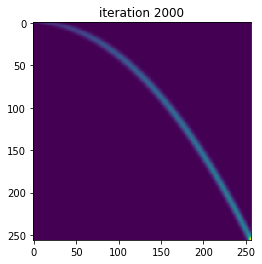

In [42]:
gamma = 0.0005
maxiters = 2001
 
n = 256

x = np.linspace(0,1,n)
c = np.linspace(0,1,n) # domain for cost

## test problem (dist = 1)

# source = np.zeros((n,1)) 
# target = np.zeros((n,1))
# source[0] = 1
# target[-1] = 1

source = 2*x
source = (source / np.sum(source)).reshape((source.shape[0],1))
target = np.ones(n)
target = (target / np.sum(target)).reshape((target.shape[0],1))

i, j = np.meshgrid(c, c)
cost = pairwise_distances(x.reshape(-1,1), 
                         x.reshape(-1,1),
                         metric='sqeuclidean')
M = np.exp(-cost/gamma)

mu = np.ones((n,1))
nu = np.ones((n,1))

for k in range(maxiters):
    mu = np.divide(source, np.dot(M, nu))
    nu = np.divide(target, np.dot(M.T, mu))
    pi = np.dot(
        np.dot(
            np.diag(nu.reshape(-1)),
            M),
        np.diag(mu.reshape(-1))
    )
    
    sinkhorn_distance = np.sqrt(sum(sum(np.multiply(pi, cost))))
    
    if k % 1000 == 0: 
        print('Sinkhorn distance: ' + str(sinkhorn_distance))
        plt.imshow(np.divide(pi, pi.max()))
        plt.title('iteration ' + str(k))
        plt.show()